In [1]:
import sys
sys.path.append('E:\Data Analysis\Python爬虫\基金数据爬取')
import mysql_helper
helper = mysql_helper.MysqlHelper()

In [2]:
from lxml import etree
from selenium import webdriver
import numpy as np
import re
import requests
import time
import pandas as pd
import datetime

In [3]:
# 爬取近几年Top100的混合基金list
def top100_fund(url, click_text =None, waittime=10):
    
    browser = webdriver.Chrome('chromedriver')
    browser.get(url)
    time.sleep(waittime)
    if click_text:
        click_button = browser.find_element_by_link_text(click_text)
        click_button.click()
        time.sleep(3)
    html = browser.page_source
    browser.quit()
    
    # 通过xpath定位需要的数据
    tree = etree.HTML(html)
    table_xpath = '//div[@class="tableMain"]/table[@class="mainTb"]/tbody/tr'
    table_data = [tr.xpath('.//td/text() | .//td[@class="fname"]/a/text() | .//td/span[@class="date"]/text() | .//td[@class="fname"]/a/@href') for tr in tree.xpath(table_xpath)]
    
    return table_data

In [4]:
# 具体某只基金持仓页的持仓数据爬取
def fund_cc_details(url, year=None, waittime=10, insert_sql=None):
#     url = 'http://fundf10.eastmoney.com/ccmx_000336.html'

    # 通过selenium获取需要的html
    browser = webdriver.Chrome('chromedriver')
    browser.get(url)
    time.sleep(waittime)
    if year: # 仅限于对基金页面年份的选择
        year_button = browser.find_element_by_css_selector('div#pagebar label[value="'+str(year)+'"]')
        year_button.click()
        time.sleep(3)
    html = browser.page_source
    browser.quit()

    # 通过xpath定位需要的数据
    tree = etree.HTML(html)
    # 定位基金title和code
    title_xpath = '//h4[@class="title"]/a/text()'
    title = tree.xpath(title_xpath)[0].split(' ')

    # 定位需要持仓数据
    cc_xpath = '//div[@id="cctable"]/div[@class="box"]'
    cc_boxes = tree.xpath(cc_xpath)
    cc_data_list = []
    for i in range(len(cc_boxes)):
        # 每个季度
        quarter = cc_boxes[i].xpath('.//label[@class="left"]/text()')[0].strip()
        cc_data = [record.xpath('.//td/a[1]/text() | .//td[@class="tor"]/text()') for record in cc_boxes[i].xpath('.//tbody/tr')]

        # 在每个record上添加所属的季度，基金代码，基金名称
        cc_data2 = [title + [quarter] + cc_data[j] for j in range(len(cc_data))]
        
        # 是否要存储到数据库
        if insert_sql:
            print('正在将数据存储至数据库中...')
            try:
                for each_record in cc_data2:
                    helper.execute_modify_sql(insert_sql, each_record)
            except:
                print("存储失败...")
        # 将所有的季度存储到同一个列表中
        cc_data_list.append(cc_data2)
    return cc_data_list

# 数据采集

## 提取基金主页信息
通过爬取天天基金网混合基金网站，截取近2年累计收益率前100名的基金列表

In [5]:
# 获取基金主页列表数据
url = 'http://fund.eastmoney.com/trade/hh.html'
fund_page = top100_fund(url=url,click_text='近2年')

In [6]:
# 定义字段名
column_names = ['基金代码','基金链接','基金名称','日期','日增长率','近1周','近1月','近3月','近6月','近1年','近2年','近3年','今年来','成立来']

# 将数据封装到DataFrame
fund_df = pd.DataFrame(data=fund_page, columns=column_names)

# 因为不同基金更新的时段不同，所以第二天获取前一天的最新数据，日期定位到更新日期
yesterday = (datetime.date.today() + datetime.timedelta(-1)).strftime('%Y-%m-%d')
yesterday

'2021-03-16'

In [7]:
# 将列表信息储存到本地
fund_df.to_csv('top100_fundlist_'+yesterday+'.csv',index=False,encoding='gbk')

## 提取基金股票持仓数据
提取`f_df`中每一只基金对应年份对应季度的股票重仓数据，需要包含的数据变量有：

- 基金代码
- 股票代码
- 股票名称
- 持仓占比
- 持仓截止日期

> 根据基金链接和年份获取该基金对应年份的所有持仓数据，更多持仓数据的链接可以通过基金链接来获取，如：
**万家行业优选混合(LOF)**
- 基金链接：http://fund.eastmoney.com/161903.html 
- 更多持仓数据链接：http://fundf10.eastmoney.com/ccmx_161903.html  
更多持仓数据链接是在基金链接的`基金代码`前面增加了`ccmx_`，在`fund`后面增加了`f10`

In [8]:
# 通过基金url生成基金持仓url
fund_df['基金持仓链接']= fund_df['基金链接'].str.replace('http://fund.eastmoney.com/','http://fundf10.eastmoney.com/').apply(lambda x:x[:-11] + 'ccmx_' + x[-11:])

1. 将持仓数据存至数据库中：
    - 先在数据库中创建表
    ```mysql
    CREATE TABLE IF NOT EXISTS fund_cc_2021_03_16 (
    基金名称 VARCHAR(255),
    基金代码 VARCHAR(255),
    年份季度 VARCHAR(255),
    股票代码 VARCHAR(255),
    股票名称 VARCHAR(255),
    变动详情 VARCHAR(255),
    占净值比例 VARCHAR(255),
    持股数 VARCHAR(255),
    持仓市值 VARCHAR(255)) DEFAULT CHARSET = UTF8mb4;
    ```

2. 开始爬取数据，并存储到数据库中

In [ ]:
insert_sql = "INSERT INTO fund_cc_2021_03_16 VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"
# 开始爬取
start_time = time.time()
for i, url in enumerate(fund_df['基金持仓链接']):
    # 大量爬取可能会出现网络问题，如出现，则忽略，继续爬取下一个基金信息
    print('正在爬取第{}只基金：{}'.format(i+1, url))
    try:
        # 这是上面获取持仓的函数，需要输入参数
        fund_cc = fund_cc_details(url, year=2020, insert_sql=insert_sql)
#         if (i > 0):
#             allfund_cc = np.append(allfund_cc,fund_cc,axis=0)
#         else:
#             allfund_cc = fund_cc
        print('---爬取成功---')
    except:
        print('---爬取失败---')
        continue
    print('---'*20)
end_time = time.time()
run_time = (end_time - start_time)
print("运行时间共计：{:.2f}秒".format(run_time))

由于网络内存和计算机性能的问题，从100只基金中成功爬取84只基金数据，供***84 * 40  = 3360***条记录 
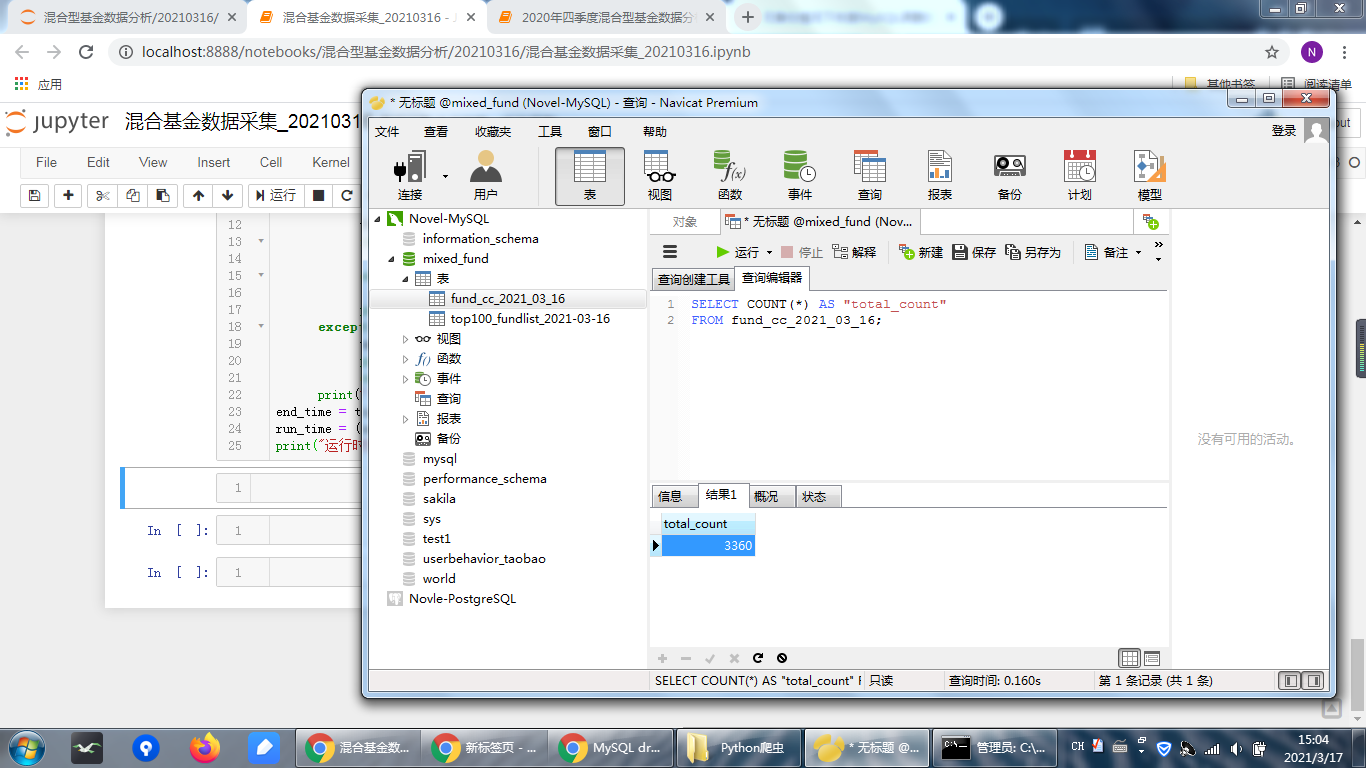

In [50]:
# 匹配数据，从top100_fundlist_2021-03-16匹配哪些基金缺失持仓数据

# 从数据库中提取数据
import pymysql

conn = pymysql.connect(host='localhost',
                      user='root',
                      password='1234567890',
                      db='mixed_fund',
                      charset='utf8mb4',
                      cursorclass=pymysql.cursors.SSDictCursor)
try:
    with conn.cursor() as cursor:

        # read a single record
        sql_list = 'SELECT * FROM top100_fundlist_2021_03_16'
        sql_cc = 'SELECT * FROM fund_cc_2021_03_16'
        cursor.execute(sql_cc)
        fund_cc = cursor.fetchall()
        cursor.execute(sql_list)
        fund_list = cursor.fetchall()
finally:
    cursor.close()
    conn.close()

In [51]:
fund_cc_df = pd.DataFrame(fund_cc)
fund_cc_df.head()

,基金名称,基金代码,年份季度,股票代码,股票名称,变动详情,占净值比例,持股数,持仓市值
0,广发鑫享混合,(002132),2020年4季度股票投资明细,002493,荣盛石化,变动详情,8.68%,398.00,"10,988.78"
1,广发鑫享混合,(002132),2020年4季度股票投资明细,601233,桐昆股份,变动详情,7.05%,433.37,"8,923.02"
2,广发鑫享混合,(002132),2020年4季度股票投资明细,000725,京东方A,变动详情,5.10%,"1,074.79","6,448.74"
3,广发鑫享混合,(002132),2020年4季度股票投资明细,002353,杰瑞股份,变动详情,4.94%,178.50,"6,247.50"
4,广发鑫享混合,(002132),2020年4季度股票投资明细,603225,新凤鸣,变动详情,4.59%,418.02,"5,810.47"


In [52]:
fund_list_df = pd.DataFrame(fund_list)
fund_list_df.head()

,基金代码,基金链接,基金名称,日期,日增长率,近1周,近1月,近3月,近6月,近1年,近2年,近3年,今年来,成立来
0,000336,http://fund.eastmoney.com/000336.html,农银研究精选混合,03-16,0.71%,1.41%,-17.94%,3.69%,22.69%,116.10%,197.45%,153.64%,-9.31%,232.82%
1,002132,http://fund.eastmoney.com/002132.html,广发鑫享混合,03-16,0.04%,0.46%,-15.37%,6.98%,24.59%,92.99%,183.27%,135.37%,1.51%,142.20%
2,001679,http://fund.eastmoney.com/001679.html,前海开源中国稀缺资产混合A,03-16,0.41%,1.30%,-22.28%,4.37%,23.52%,99.33%,178.38%,283.18%,-5.06%,196.20%
3,002079,http://fund.eastmoney.com/002079.html,前海开源中国稀缺资产混合C,03-16,0.45%,1.31%,-22.26%,4.38%,23.50%,99.17%,177.87%,281.90%,-5.05%,210.10%
4,002939,http://fund.eastmoney.com/002939.html,广发创新升级混合,03-16,1.28%,1.96%,-23.17%,3.33%,8.40%,44.19%,174.32%,150.83%,-5.72%,222.39%


In [53]:
# 开始匹配，找错
#修改fund_cc里面的基金编码
fund_cc_df['基金代码'] = fund_cc_df['基金代码'].str.replace("(","").str.replace(")","")

# 将两个表之间进行匹配
fund_merge_df = pd.merge(fund_list_df,fund_cc_df,how="left",on="基金代码")
# 获取含有na值的记录
missed_record = fund_merge_df[fund_merge_df.isna().any(axis=1)]
missed_record.shape

(3, 22)

有16只基金没有在上一次爬取中成功获取，现再次对这些未成功爬取到的基金重新执行爬取程序

In [54]:
urls = missed_record['基金链接'].str.replace('http://fund.eastmoney.com/','http://fundf10.eastmoney.com/').apply(lambda x:x[:-11] + 'ccmx_' + x[-11:])
insert_sql = "INSERT INTO fund_cc_2021_03_16 VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"
# 开始爬取
start_time = time.time()
for i, url in enumerate(urls):
    # 大量爬取可能会出现网络问题，如出现，则忽略，继续爬取下一个基金信息
    print('正在爬取第{}只基金：{}'.format(i+1, url))
    try:
        # 这是上面获取持仓的函数，需要输入参数
        fund_cc = fund_cc_details(url, year=2020, insert_sql=insert_sql)
        print('---爬取成功---')
    except:
        print('---爬取失败---')
        continue
    print('---'*20)
end_time = time.time()
run_time = (end_time - start_time)
print("运行时间共计：{:.2f}秒".format(run_time))

正在爬取第1只基金：http://fundf10.eastmoney.com/ccmx_005050.html
正在将数据存储至数据库中...
正在将数据存储至数据库中...
正在将数据存储至数据库中...
正在将数据存储至数据库中...
---爬取成功---
------------------------------------------------------------
正在爬取第2只基金：http://fundf10.eastmoney.com/ccmx_002669.html
正在将数据存储至数据库中...
正在将数据存储至数据库中...
正在将数据存储至数据库中...
正在将数据存储至数据库中...
---爬取成功---
------------------------------------------------------------
正在爬取第3只基金：http://fundf10.eastmoney.com/ccmx_002082.html
正在将数据存储至数据库中...
正在将数据存储至数据库中...
正在将数据存储至数据库中...
正在将数据存储至数据库中...
---爬取成功---
------------------------------------------------------------
运行时间共计：116.58秒


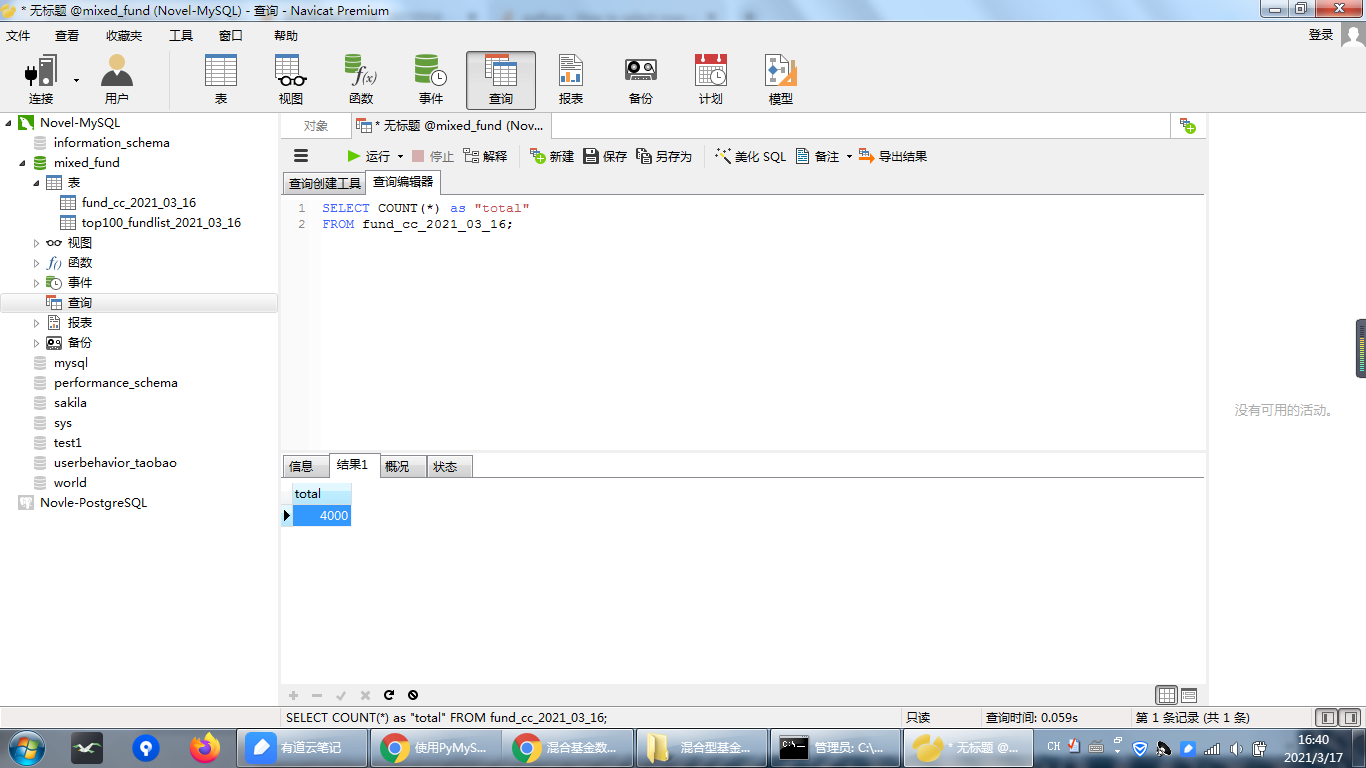

循环三次爬取程序，成功将100只基金数据全部爬取